In [18]:
# import matplotlib.pyplot as plt
# from sklearn import datasets, metrics, svm
# from sklearn.model_selection import train_test_split

In [19]:
# digits = datasets.load_digits()

# _, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
# for ax, image, label in zip(axes, digits.images, digits.target):
#     ax.set_axis_off()
#     ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
#     ax.set_title("Training: %i" % label)

In [20]:
# digits["data"].shape

In [21]:
# digits

In [22]:
# from sklearn.datasets import load_digits
# from sklearn.cluster import KMeans

# # Load the dataset
# digits = load_digits()

# # Create a KMeans object with 10 clusters
# kmeans = KMeans(n_clusters=10) #, n_init='auto'

# # Fit the model to the data
# kmeans.fit(digits.data)

# # Get the cluster labels for each data point
# labels = kmeans.labels_


In [23]:
# # flatten the images
# n_samples = len(digits.images)
# data = digits.images.reshape((n_samples, -1))

# # Create a classifier: a support vector classifier
# clf = svm.SVC(gamma=0.001)

# # Split data into 50% train and 50% test subsets
# X_train, X_test, y_train, y_test = train_test_split(
#     data, digits.target, test_size=0.5, shuffle=False
# )

# # Learn the digits on the train subset
# clf.fit(X_train, y_train)

# # Predict the value of the digit on the test subset
# predicted = clf.predict(X_test)

In [24]:
# _, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
# for ax, image, prediction in zip(axes, X_test, predicted):
#     ax.set_axis_off()
#     image = image.reshape(8, 8)
#     ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
#     ax.set_title(f"Prediction: {prediction}")

In [25]:
# print(
#     f"Classification report for classifier {clf}:\n"
#     f"{metrics.classification_report(y_test, predicted)}\n"
# )

In [26]:
# disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
# disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")

# plt.show()

In [27]:
# # The ground truth and predicted lists
# y_true = []
# y_pred = []
# cm = disp.confusion_matrix

# # For each cell in the confusion matrix, add the corresponding ground truths
# # and predictions to the lists
# for gt in range(len(cm)):
#     for pred in range(len(cm)):
#         y_true += [gt] * cm[gt][pred]
#         y_pred += [pred] * cm[gt][pred]

# print(
#     "Classification report rebuilt from confusion matrix:\n"
#     f"{metrics.classification_report(y_true, y_pred)}\n"
# )

doc scikit learn

Load the dataset

In [28]:
import numpy as np

from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


Define our evaluation benchmark

In [29]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

Run the benchmark

In [30]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os

os.environ['OMP_NUM_THREADS'] = '8'

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.116s	69545	0.598	0.645	0.621	0.469	0.617	0.154


c:\Users\alaja\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\alaja\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


random   	0.119s	69735	0.681	0.723	0.701	0.574	0.698	0.166
PCA-based	0.048s	72686	0.636	0.658	0.647	0.521	0.643	0.148
__________________________________________________________________________________


c:\Users\alaja\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Visualize the results on PCA-reduced data

c:\Users\alaja\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


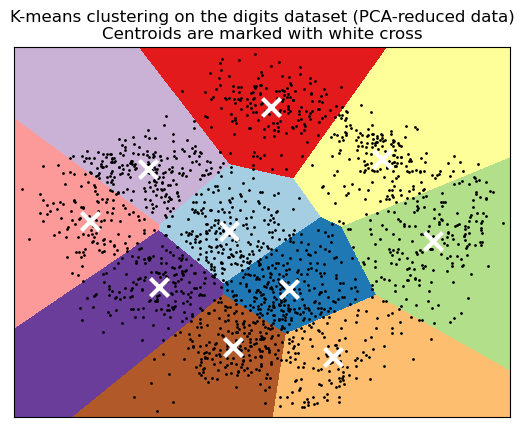

In [31]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [5]:
import numpy as np
import pyaudio

def record_sound():
    # Changer les paramètres audio
    sample_rate = 16000
    sample_size = 1
    channels = 1
    duration = 5 # en secondes

    # Initialisation numpy array
    sound_data = np.empty((int(duration * sample_rate), 1), dtype=np.float32)

    # Initialisation PyAudio
    p = pyaudio.PyAudio()

    # Obtenir la forme data du microphone
    stream = p.open(format=pyaudio.paFloat32, channels=channels, rate=sample_rate, input=True)

    # enregistre le son dans l'array numpy
    for i, data in enumerate(stream):
        sound_data[i] = data

    # Fermer le flux audio et PyAudio
    stream.close()
    p.close()

    return sound_data

In [10]:
sound_data.np

NameError: name 'sound_data' is not defined

In [17]:
import numpy as np
import pyaudio

def record_sound():
    # Audio parameters
    sample_rate = 16000
    sample_size = 2  # Typically, audio samples are 16-bit (2 bytes)
    channels = 1
    duration = 5  # in seconds
    buffer_size = 1024  # Number of frames per buffer

    # Calculate the total number of frames to read
    total_frames = int(duration * sample_rate)

    # Initialize PyAudio
    p = pyaudio.PyAudio()

    # Open stream
    stream = p.open(format=pyaudio.paInt16, channels=channels, rate=sample_rate, input=True)

    # Initialize an empty list to store frames
    frames = []

    # Read data from the stream
    for _ in range(0, total_frames, buffer_size):
        data = stream.read(buffer_size)
        frames.append(np.frombuffer(data, dtype=np.int16))

    # Concatenate all frames
    sound_data = np.concatenate(frames)

    # Normalize the data
    sound_data = sound_data / np.power(2, sample_size * 8 - 1)

    # Close stream and PyAudio
    stream.stop_stream()
    stream.close()
    p.terminate()

    return sound_data


In [21]:
import numpy as np
import pyaudio

def play_sound(sound_data, sample_rate=16000):
    # Initialisation de PyAudio
    p = pyaudio.PyAudio()

    # Configuration du flux de sortie
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=sample_rate,
                    output=True)

    # Jouer le son
    # Assurez-vous que les données sont de type float32
    if sound_data.dtype != np.float32:
        sound_data = sound_data.astype(np.float32)

    # Convertir les données en bytes et les jouer
    stream.write(sound_data.tobytes())

    # Fermer le flux et PyAudio
    stream.stop_stream()
    stream.close()
    p.terminate()

# Exemple d'utilisation
# sound_data est l'array numpy contenant vos données audio enregistrées
# play_sound(sound_data)


In [4]:
import pyaudio
import wave

def record_audio(filename, duration=5, sample_rate=16000, chunk_size=1024):
    audio_format = pyaudio.paInt16
    channels = 1

    p = pyaudio.PyAudio()

    stream = p.open(format=audio_format, channels=channels, rate=sample_rate, input=True, frames_per_buffer=chunk_size)

    print("Enregistrement en cours...")

    frames = []

    for _ in range(0, int(sample_rate / chunk_size * duration)):
        data = stream.read(chunk_size)
        frames.append(data)

    print("Enregistrement terminé.")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(audio_format))
    wf.setframerate(sample_rate)
    wf.writeframes(b''.join(frames))
    wf.close()

# Exemple d'utilisation
record_audio("test.wav", duration=5)


Enregistrement en cours...
Enregistrement terminé.


In [1]:
import pyaudio
import wave

def play_audio(filename):
    wf = wave.open(filename, 'rb')

    p = pyaudio.PyAudio()

    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)

    data = wf.readframes(1024)

    while data != '':
        stream.write(data)
        data = wf.readframes(1024)

    stream.stop_stream()
    stream.close()

    p.terminate()

# Exemple d'utilisation
play_audio("test.wav")


KeyboardInterrupt: 